In [59]:
import matplotlib.pyplot as plt
import numpy as np

import regions
import photutils
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.nddata import CCDData

from skycam_utils.photometry import make_background, make_segmentation_image
from skycam_utils.astrometry import solve_field

In [46]:
hdul = fits.open("../2018/image_0003000.fits")
im = hdul[0].data
hdr = hdul[0].header

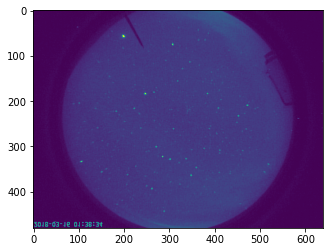

In [47]:
plt.imshow(im)

In [48]:
fov = regions.read_ds9("fov.reg")[0].to_mask(mode='exact')
mmt = regions.read_ds9("mmt.reg")[0].to_mask(mode='subpixels')
pole = regions.read_ds9("pole.reg")[0].to_mask(mode='subpixels')
center = regions.read_ds9("small.reg")[0].to_mask(mode='subpixels')

sh = im.shape
mask_image = fov.to_image(sh) - mmt.to_image(sh) - pole.to_image(sh)
mask_image[mask_image <= 0] = np.nan

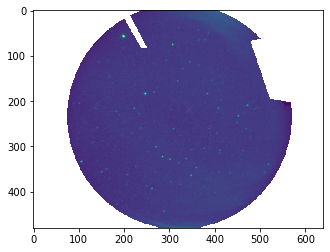

In [49]:
plt.imshow(mask_image * im)

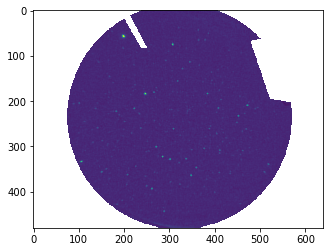

In [50]:
masked_im = np.ma.masked_where(mask_image == np.nan, im)
bkg = make_background(masked_im, boxsize=(5, 5), filter_size=(3, 3))
plt.imshow(im - bkg.background * mask_image)

In [53]:
subt = CCDData(im - bkg.background * mask_image, unit=u.adu)
subt.write("masked_subt.fits", overwrite=True)

In [52]:
solved_fp = solve_field("masked_subt.fits", x_size=300, y_size=300)

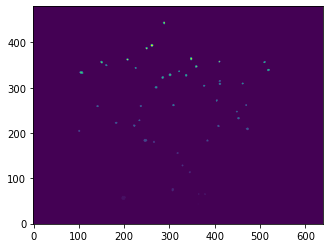

In [58]:
segm = make_segmentation_image(subt.data)
plt.imshow(segm, origin='lower')

In [65]:
cat = photutils.source_properties(subt.data, segm)
t = cat.to_table()
t['obs_mag'] = -2.5 * np.log10(t['source_sum'])
t.sort('obs_mag')

In [66]:
t

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,obs_mag
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,,
int64,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,199.29037638149657,57.05401049731356,None,None,6456.193128407812,None,None,None,None,195.0,204.0,53.0,61.0,2.8187880255221742,215.95662834692845,203.0,60.0,200.0,58.0,72.0,4.787307364817192,28.72792206135785,1.949623054120608,1.5811490888358197,44.042842403578184,0.5850427448561856,0.18899754211769482,1.2330418857314025,3.1722610864053826,0.6501357632940948,3.1288014078795277,0.3292539931453304,-0.1368318203974742,0.3338273970882632,0.47953006026489287,-9.524941283121505
10,247.36933877990475,183.66010102015497,None,None,2960.865761886431,None,None,None,None,244.0,251.0,181.0,186.0,-2.6297057522333915,212.5118352399441,250.0,182.0,247.0,183.0,37.0,3.431831258788849,20.48528137423857,1.396049197664111,1.099623999445871,10.644579853535282,0.6160992690203322,0.21233148424441117,1.2695695968509384,1.92371203121689,0.1342978695596624,1.2344142712390507,0.5238067222910608,-0.1139749085922489,0.8163007486069973,0.5085925132274346,-8.678546795074459
5,307.9303286335745,75.05974418804972,None,None,2178.15234733162,None,None,None,None,306.0,310.0,72.0,78.0,-5.292396209835381,211.75392359232907,306.0,77.0,308.0,75.0,29.0,3.0382538898732494,17.071067811865476,1.3184507958537222,0.9211056473583803,80.12400165142289,0.715485829593943,0.30137275486117265,1.4313784739403994,0.8746139056891313,0.15036673206262066,1.7121342089936826,1.160889976274287,-0.2039083514594524,0.5930204016082264,0.5022208202577892,-8.345220631262372
33,106.38244506303121,332.9998048257094,None,None,2003.1360906513,None,None,None,None,103.0,110.0,331.0,335.0,-4.0425615197626,222.81244082498577,109.0,334.0,106.0,333.0,31.0,3.141274657157109,18.48528137423857,1.5331943314929082,0.8112775201472091,-15.961929080090702,0.8485332876510887,0.4708579966133526,1.889851861314615,2.2226898428742254,-0.44749367109384985,0.7861662299439655,0.5081373172805197,0.5784736735533587,1.4366321153037442,0.5414264605331235,-8.2542761393487
32,302.07211453216723,327.93759284531194,None,None,1454.7909587455663,None,None,None,None,300.0,304.0,326.0,330.0,-7.770160004048435,200.23523690863297,304.0,329.0,302.0,328.0,21.0,2.5854414729132054,13.65685424949238,0.9432501649529227,0.8459514386365317,-42.45864639219815,0.44234011564795,0.1031526205153086,1.1150169168968056,0.8103888600129976,-0.08670125038444249,0.7949658502019358,1.2485439269188456,0.27233954665164134,1.2727667350174823,0.5552652176851106,-7.907001483329673
13,472.72109382789165,209.08327743822878,None,None,1437.6559735485512,None,None,None,None,470.0,475.0,207.0,211.0,2.61830081038552,210.41169210610366,474.0,207.0,473.0,209.0,23.0,2.7057581899030048,15.071067811865476,1.1307408970786725,0.7365833294594168,-0.7739906619781558,0.7587202934907699,0.3485834541207292,1.535116057959838,1.2784406721985009,-0.00994145277032125,0.5426893053653001,0.7823143410718892,0.02866222347269589,1.8429375006703834,0.5755242684228913,-7.894137433015997
43,348.43914825869354,363.32798855142556,None,None,1358.7954605893242,None,None,None,None,347.0,350.0,361.0,366.0,-3.9899897229923056,183.1425186275983,350.0,365.0,348.0,364.0,20.0,2.5231325220201604,13.65685424949238,1.0279378360272498,0.7591549608712707,88.26093540933844,0.674229

In [27]:
wcs = WCS("masked_subt.wcs")

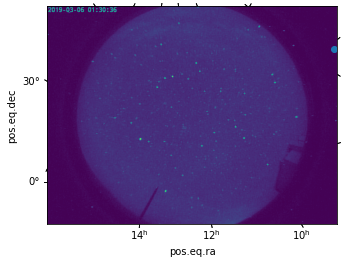

In [55]:
ax = plt.subplot(projection=wcs)
#plt.grid(color='white', ls='solid')
ax.imshow(im)
co_x, co_y = 116.3 * u.deg, 28.0 * u.deg
ax.scatter(co_x, co_y, transform=ax.get_transform('world'))
plt.show()

In [54]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 183.250957378  25.6532371745  
CRPIX : 313.896687826  211.121007284  
CD1_1 CD1_2  : -0.271203202065  -0.0358738590292  
CD2_1 CD2_2  : -0.0348827990897  0.2743735958  
NAXIS : 0  0